In [46]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

def ng_factors(Y, rmax=10):
    import numpy as np

    p, n = Y.shape
    Y = Y - np.mean(Y, axis=0, keepdims=True)  # Column-wise centering

    c = np.linspace(0.05, 5, 100)
    re = 20
    IC = np.zeros((2, re, rmax, 100))
    gT1HL = np.ones(re)
    gT2HL = np.ones(re)
    pi = np.zeros(re, dtype=int)
    ni = np.zeros(re, dtype=int)

    for i in range(re):
        pi[i] = min(i * (p // re) + min(p, 5), p)
        ni[i] = min(i * (n // re) + min(n, 5), n)
        if i == re - 1:
            pi[i] = p
            ni[i] = n

        Yi = Y[:pi[i], :ni[i]]
        frob = np.zeros(rmax)

        for k in range(min(pi[i], ni[i], rmax)):
            eigenvals, V = np.linalg.eigh(Yi.T @ Yi)
            idx = eigenvals.argsort()[::-1]
            V = V[:, idx]
            F = V[:, : k + 1]
            LamPCA = Yi @ F / ni[i]
            uhat = Yi - LamPCA @ F.T
            frob[k] = np.trace(uhat @ uhat.T) / (pi[i] * ni[i])

            gT1HL[i] = (
                np.log((pi[i] * ni[i]) / (pi[i] + ni[i]))
                * (pi[i] + ni[i])
                / (pi[i] * ni[i])
            )
            gT2HL[i] = (
                np.log(min(pi[i], ni[i]))
                * (pi[i] + ni[i])
                / (pi[i] * ni[i])
            )

            for l in range(100):
                IC[0, i, k, l] = np.log(frob[k]) + c[l] * (k + 1) * gT1HL[i]
                IC[1, i, k, l] = np.log(frob[k]) + c[l] * (k + 1) * gT2HL[i]

    rhat = np.zeros((2, re, 100))
    for i in range(re):
        for l in range(100):
            m = min(pi[i], ni[i], rmax)
            rhat[0, i, l] = np.argmin(IC[0, i, :m, l]) + 1
            rhat[1, i, l] = np.argmin(IC[1, i, :m, l]) + 1

    Sc1 = np.std(rhat[0], axis=0)
    Sc2 = np.std(rhat[1], axis=0)

    c1vec = np.where(Sc1 == 0)[0]
    ctemp1 = c1vec[0]
    c1 = c[ctemp1]
    K1HL = int(rhat[0, 0, ctemp1])

    c2vec = np.where(Sc2 == 0)[0]
    ctemp2 = c2vec[0]
    c2 = c[ctemp2]
    K2HL = int(rhat[1, 0, ctemp2])

    IC = np.zeros((2, rmax))
    frob = np.zeros(rmax)

    for k in range(rmax):
        eigenvals, V = np.linalg.eigh(Y.T @ Y)
        idx = eigenvals.argsort()[::-1]
        V = V[:, idx]
        F = V[:, : k + 1]
        LamPCA = Y @ F / n
        uhat = Y - LamPCA @ F.T
        frob[k] = np.trace(uhat @ uhat.T) / (p * n)

        gT1BN = np.log((p * n) / (p + n)) * (p + n) / (p * n)
        gT2BN = np.log(min(p, n)) * (p + n) / (p * n)
        IC[0, k] = np.log(frob[k]) + (k + 1) * gT1BN
        IC[1, k] = np.log(frob[k]) + (k + 1) * gT2BN

    K1BN = np.argmin(IC[0]) + 1
    K2BN = np.argmin(IC[1]) + 1

    return {"K1HL": K1HL, "K2HL": K2HL, "K1BN": K1BN, "K2BN": K2BN, "IC": IC}


def st_facm(data, coords, typeD="COR", Wmat=None, maxitr=100, G=4, tol=0.0001):
    N = data.shape[1]

    # Step 1: Estimate K global factors
    K = ng_factors(data)["K1BN"] 

    # Step 2: Retrieve global factors (GF)
    cov_matrix = np.cov(data, rowvar=False)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
    P = eig_vectors[:, -K:] * np.sqrt(N)
    GF = (data @ P) / N

    # Step 3: Residuals (ResTS)
    E = data - GF @ P.T

    # Step 4: Spatio-temporal clustering of the residual

    # 4.1: TS Distance (D0)
    if typeD == "COR":
        # Calculate pairwise correlations
        cor_matrix = np.corrcoef(E.T)

        # Compute dissimilarity using the formula d1 = sqrt(2 * (1 - rho))
        D0_full = np.sqrt(2 * (1 - cor_matrix))

        # Normalize by the maximum value
        D0_full = D0_full / np.max(D0_full)

        # Initialize D0 as a zeros matrix
        D0 = np.zeros((N, N))

        # Extract only the lower triangular part (excluding diagonal)
        tril_indices = np.tril_indices(N, k=-1)
        D0[tril_indices] = D0_full[tril_indices]

        # Make the matrix symmetrical
        D0 = D0 + D0.T  # Add the transpose to mirror values above diagonal
    else:
        raise ValueError("Unsupported distance type")

    # 4.2: Spatial Distance (D1)
    if Wmat is None:
        D1 = squareform(pdist(coords))
        D1 = D1 / np.max(D1)
    else:
        Adj = Wmat.copy()
        np.fill_diagonal(Adj, 1)
        D1 = 1 - Adj

    res_hc = geo_clustf(D0, D1)
    hc = res_hc["clust"]

    # Sort heights in decreasing order (matching R's sort(res.hc$clust$height,decreasing = T))
    heights = np.sort(hc[:, 2])[::-1]  
    # Create matching x-values array (1 to N-1)
    x_values = np.arange(1, len(heights) + 1)

    # Plot screeplot
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, heights, 'b-', marker='o')
    plt.title("Screeplot - spatio-temporal clustering")
    plt.ylabel("Height")
    plt.xlabel("Clusters")
    plt.show()

    # Determine optimal number of clusters
    if G is None:
        # Create x_values array of same length as heights
        x_range = np.arange(1, len(heights) + 1)
        nclust = elbow_finder(x_range, heights)[0]  # Use first element to get cluster number
    else:
        nclust = G


    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(hc)
    plt.title("Dendrogram")
    plt.show()

    clustering = fcluster(hc, t=nclust, criterion='maxclust')


    # Step 4: Estimating c-th local factors (c-LF)
    cLF = []
    Pc = []
    resC = []

    for c in range(1, nclust + 1):
        indices = np.where(clustering == c)[0]
        if len(indices) > K:
            dataclust = E[:, indices]
            rmax = min(len(indices), K)
            cov_dataclust = np.cov(dataclust, rowvar=False)
            eig_values, eig_vectors = np.linalg.eigh(cov_dataclust)
            Pc_c = eig_vectors[:, -rmax:] * np.sqrt(len(indices))
            cLF_c = (dataclust @ Pc_c) / len(indices)
            cLF.append(cLF_c)
            Pc.append(Pc_c)
            resC.append(dataclust - cLF_c @ Pc_c.T)
        else:
            cLF.append(0)
            Pc.append(0)
            resC.append(E[:, indices])


    #valvec = [np.sum(np.square(E)) / (N * data.shape[0])]

    # Initialize valvec and calculate initial value
    valvec = np.zeros(maxitr)
    val = np.sum([np.square(res).sum() for res in resC]) / (N * data.shape[0])
    valvec[0] = val

    # Main iteration loop
    for z in range(maxitr):
        cval = val
        
        # Calculate R matrix
        R = np.zeros_like(data)
        for c in range(nclust):
            cluster_mask = clustering == (c + 1)
            if isinstance(cLF[c], int):  # When cLF[c] == 0
                R[:, cluster_mask] = data[:, cluster_mask]
            else:
                R[:, cluster_mask] = data[:, cluster_mask] - cLF[c] @ Pc[c].T
    # Update global factors
        K = ng_factors(R)["K1BN"]
        cov_matrix = np.cov(R, rowvar=False)
        eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
        P = eig_vectors[:, -K:] * np.sqrt(N)
        GF = (R @ P) / N

        # Update residuals (E-tilde)
        for c in range(nclust):
            cluster_mask = clustering == (c + 1)
            if isinstance(cLF[c], int):  # When cLF[c] == 0
                E[:, cluster_mask] = R[:, cluster_mask] - GF @ P.T[:, cluster_mask]
            else:
                E[:, cluster_mask] = (R[:, cluster_mask] - GF @ P.T[:, cluster_mask] + 
                                    cLF[c] @ Pc[c].T)

        # Update clustering
        if typeD == "COR":
            cor_matrix = np.corrcoef(E.T)
            D0_full = np.sqrt(2 * (1 - cor_matrix))
            D0_full = D0_full / np.max(D0_full)
            D0 = np.zeros((N, N))
            tril_indices = np.tril_indices(N, k=-1)
            D0[tril_indices] = D0_full[tril_indices]
            D0 = D0 + D0.T

        res_hc = geo_clustf(D0, D1)
        hc = res_hc["clust"]
        
        if G is None:
            heights = np.sort(hc[:, 2])[::-1]
            nclust = elbow_finder(np.arange(1, len(heights) + 1), heights)[0]
        
        clustering = fcluster(hc, t=nclust, criterion='maxclust')

        # Update local factors
        cLF = []
        Pc = []
        resC = []

        for c in range(1, nclust + 1):
            indices = np.where(clustering == c)[0]
            if len(indices) > K:
                dataclust = E[:, indices]
                rmax = min(len(indices), K)
                cov_dataclust = np.cov(dataclust, rowvar=False)
                eig_values, eig_vectors = np.linalg.eigh(cov_dataclust)
                Pc_c = eig_vectors[:, -rmax:] * np.sqrt(len(indices))
                cLF_c = (dataclust @ Pc_c) / len(indices)
                cLF.append(cLF_c)
                Pc.append(Pc_c)
                resC.append(dataclust - cLF_c @ Pc_c.T)
            else:
                cLF.append(0)
                Pc.append(0)
                resC.append(E[:, indices])
        
    # Update convergence values
        val = np.sum([np.square(res).sum() for res in resC]) / (N * data.shape[0])
        valvec[z + 1] = val
        
        # Check convergence
        dd = (cval - val) / val
        if abs(dd) < tol:
            break

    # Return final results
    return {
        "Global_Factors": GF,
        "Local_Factors": cLF,
        "Residuals": E,
        "nclust": nclust,
        "Global_Loadings": P,
        "Local_Loadings": Pc,
        "Weights": res_hc["Weights"],
        "clustering": clustering,
        "itr": z + 1,
        "obj": val
    }       


def ando_yclust(Y, ng_factor, nl_factors, maxit=100, tol=0.0001):
    n_groups = len(nl_factors)
    ay = Y.copy()
    p, n = ay.shape
    z = ay.copy()

    eigenvals, vec = np.linalg.eigh(np.cov(z))
    idx = eigenvals.argsort()[::-1]
    vec = vec[:, idx]
    l_temp = np.sqrt(n) * vec[:, : sum(nl_factors)]
    f_temp = (z @ l_temp) / n

    km = KMeans(n_clusters=n_groups).fit(l_temp)
    lab = km.labels_
    pp = np.bincount(lab)

    fs = np.zeros((p, sum(nl_factors)))
    ls = np.zeros((n, max(nl_factors)))
    pred_l = np.zeros((p, n))

    for i in range(n_groups):
        index = lab == i
        z = Y[:, index]
        eigenvals, vec = np.linalg.eigh(np.cov(z))
        idx = eigenvals.argsort()[::-1]
        vec = vec[:, idx]
        l_temp = np.sqrt(np.sum(index)) * vec[:, : nl_factors[i]]
        f_temp = (z @ l_temp) / np.sum(index)
        ls[index, : nl_factors[i]] = l_temp

        if i == 0:
            fs[:, : nl_factors[0]] = f_temp
        else:
            fs[:, sum(nl_factors[:i]) : sum(nl_factors[: i + 1])] = f_temp

        pred_l[:, index] = f_temp @ l_temp.T

    z = ay - pred_l
    eigenvals, vec = np.linalg.eigh(np.cov(z))
    idx = eigenvals.argsort()[::-1]
    vec = vec[:, idx]
    l_temp = np.sqrt(n) * vec[:, :ng_factor]
    f_temp = (z @ l_temp) / n
    fg = f_temp
    lg = l_temp
    pred_g = fg @ lg.T

    b = np.sum((ay - pred_l - pred_g) ** 2) / (n * p)

    for ite in range(maxit):
        b_old = b
        y = ay - pred_l - pred_g

        for j in range(n):
            er = np.full(n_groups, 1e7)
            for i in range(n_groups):
                if nl_factors[i] != 0:
                    if i == 0:
                        f_temp = fs[:, : nl_factors[0]]
                    else:
                        f_temp = fs[:, sum(nl_factors[:i]) : sum(nl_factors[: i + 1])]

                    l_temp = np.linalg.solve(f_temp.T @ f_temp, f_temp.T @ y[:, j])
                    er[i] = np.sum((y[:, j] - f_temp @ l_temp) ** 2)
                else:
                    er[i] = np.sum(y[:, j] ** 2)

            lab[j] = np.argmin(er)

        for i in range(n_groups):
            if nl_factors[i] != 0:
                index = lab == i
                z = y[:, index]
                eigenvals, vec = np.linalg.eigh(np.cov(z))
                idx = eigenvals.argsort()[::-1]
                vec = vec[:, idx]
                l_temp = np.sqrt(np.sum(index)) * vec[:, : nl_factors[i]]
                f_temp = (z @ l_temp) / np.sum(index)
                ls[index, : nl_factors[i]] = l_temp

                if i == 0:
                    fs[:, : nl_factors[0]] = f_temp
                else:
                    fs[:, sum(nl_factors[:i]) : sum(nl_factors[: i + 1])] = f_temp

                pred_l[:, index] = f_temp @ l_temp.T

        z = ay - pred_l
        eigenvals, vec = np.linalg.eigh(np.cov(z))
        idx = eigenvals.argsort()[::-1]
        vec = vec[:, idx]
        l_temp = np.sqrt(n) * vec[:, :ng_factor]
        f_temp = (z @ l_temp) / n
        fg = f_temp
        lg = l_temp
        pred_g = fg @ lg.T

        b = np.sum((ay - pred_l - pred_g) ** 2) / (n * p)

        if abs((b_old - b) / b) < tol:
            break

    er = ay - pred_l - pred_g

    return {
        "Factors": fg,
        "Loadings": lg,
        "nclust": n_groups,
        "GroupFactors": fs,
        "GroupLoad": ls,
        "clustering": lab,
        "itr": ite,
        "obj": np.sum(er**2),
    }


def geo_clustf(d0, d1, scale=False):
    # Step 1: Scaling the dissimilarity matrices (default False to match R)
    if scale:
        d0 = d0 / np.max(d0)
        d1 = d1 / np.max(d1)

    # Step 2: Initial Ward Clustering and Elbow Detection
    nn = d1.shape[1] - 1
    d0_dist = squareform(d0)
    res_hc0 = linkage(d0_dist, method="ward")
    heights = np.sort(res_hc0[:, 2])[::-1]  # Extract the heights
    kk = int(elbow_finder(np.arange(1, nn + 1), heights)[0])
    print(f"Elbow detected at {kk} clusters")
    # Step 3: Choice of Alpha
    alphas = np.linspace(0, 1, 11)  # Alpha range from 0 to 1 with 11 points
    q_norm = np.zeros((len(alphas), 2))  # Q0norm and Q1norm

    for i, alpha in enumerate(alphas):
        # Combine D0 and D1 with alpha
        d_alpha = (1 - alpha) * d0 + alpha * d1
        res_hc = linkage(squareform(d_alpha), method="ward")
        clustering = cut_tree(res_hc, n_clusters=4).ravel()
        
        # Calculate cluster sizes
        unique_clusters = np.unique(clustering)
        for k in unique_clusters:
            cluster_indices = clustering == k
            cluster_size = np.sum(cluster_indices)
            
            if cluster_size > 1:
                # Calculate within-cluster sums
                cluster_d0 = d0[np.ix_(cluster_indices, cluster_indices)]
                cluster_d1 = d1[np.ix_(cluster_indices, cluster_indices)]
                
                q_norm[i, 0] += np.sum(cluster_d0) / (2 * cluster_size)
                q_norm[i, 1] += np.sum(cluster_d1) / (2 * cluster_size)

    # Step 4: Optimal Alpha
    a = alphas[np.argmin(np.abs(q_norm[:, 1] - q_norm[:, 0]))]

    # Step 5: Final Clustering
    d_final = (1 - a) * d0 + a * d1
    res_hc_final = linkage(squareform(d_final), method="ward")

    return {
        "clust": res_hc_final,
        "Weights": a,
        "dist_mat": d_final
    }

def geo_clustf2(d0, d1, scale=True):
    # Step 1: Scaling the dissimilarity matrices
    if scale:
        d0 = d0 / np.max(d0)
        d1 = d1 / np.max(d1)

    # Step 2: Initial Ward Clustering and Elbow Detection
    nn = d1.shape[1] - 1
    res_hc0 = linkage(squareform(d0), method="ward")
    heights = np.sort(res_hc0[:, 2])[::-1]  # Extract the heights
    kk = int(elbow_finder(np.arange(1, nn + 1), heights)[0])
    print("kk: ", kk)
    

    # Step 3: Choice of Alpha
    alphas = np.linspace(0, 1, 11)  # Alpha range
    q_norm = np.zeros((len(alphas), 2))  # Q0norm and Q1norm

    for i, alpha in enumerate(alphas):
        # Combine D0 and D1 with alpha
        d_alpha = (1 - alpha) * d0 + alpha * d1
        res_hc = linkage(squareform(d_alpha), method="ward")
        clustering = cut_tree(res_hc, n_clusters=kk).ravel()

        # Calculate Qnorm for each cluster
        for k in range(kk):
            cluster_indices = clustering == k
            q_norm[i, 0] += np.sum(d0[np.ix_(cluster_indices, cluster_indices)])
            q_norm[i, 1] += np.sum(d1[np.ix_(cluster_indices, cluster_indices)])

    # Step 4: Optimal Alpha
    a = alphas[np.argmin(np.abs(q_norm[:, 0] - q_norm[:, 1]))]
    print("Optimal alpha: ", a)

    # Step 5: Final Clustering
    d_final = (1 - a) * d0 + a * d1
    res_hc0 = linkage(squareform(d_final), method="ward")

    return {"clust": res_hc0, "Weights": a, "dist_mat": d_final}

def elbow_finder(x, y):
    # Implement the same elbow detection as R's ClustGeo package
    nPoints = len(x)
    allCoord = np.vstack((x, y)).T
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecN = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * lineVecN, axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecN)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return idxOfBestPoint, distToLine[idxOfBestPoint]


def bic_val(model):
    n = model.nof_groups
    tk = model.nof_observations / model.nof_groups
    k = model.lags
    p = len(model.dependent_vars)
    cnt = np.log(np.sqrt(n) * tk) / (np.sqrt(n) * tk)
    sigma = np.sum(model.residuals**2) / (p * n * tk)

    return sigma + k * cnt


def fe_est(model, varsid):
    df = model.Set_Vars
    beta = model.coef[0]
    id_vals = df["category"].unique()
    fixef = np.zeros(len(id_vals))

    for i, id_val in enumerate(id_vals):
        df0 = df[df["category"] == id_val]
        fixef[i] = np.mean(df0["price"]) - beta @ np.mean(df0[varsid], axis=0)

    return fixef



In [47]:
# A. Application to house prices
Data = pd.read_csv("PriceUS.csv", header = None)
Data.columns = ["State", "Year", "Quarter", "Index"]
Data = Data.sort_values(by=['State', 'Year']).reset_index(drop=True)
Data

,State,Year,Quarter,Index
0,AK,1975,1,62.02
1,AK,1975,2,63.93
2,AK,1975,3,68.23
3,AK,1975,4,68.02
4,AK,1976,1,71.36
...,...,...,...,...
9838,WY,2022,1,416.42
9839,WY,2022,2,440.49
9840,WY,2022,3,451.48
9841,WY,2022,4,450.89


In [48]:
Prices = Data.pivot(index=["Year", "Quarter"], columns="State", values="Index")
Prices = Prices.reset_index()
Prices = Prices.iloc[:, 2:]
Prices

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,62.02,75.02,66.54,60.63,41.70,54.16,62.28,47.84,77.03,65.93,...,75.04,68.03,55.63,55.15,69.84,77.35,46.26,61.86,50.24,49.17
1,63.93,72.22,60.19,59.87,42.75,54.85,62.82,47.60,89.58,83.43,...,70.33,68.72,58.60,58.77,66.78,76.88,47.18,62.79,65.34,47.84
2,68.23,74.62,64.92,59.44,44.31,54.81,61.86,47.32,115.70,66.80,...,65.02,67.75,56.16,55.17,67.51,67.11,49.72,64.60,66.18,50.11
3,68.02,71.70,62.80,56.33,45.76,55.00,61.88,54.68,71.70,68.20,...,63.86,70.89,59.34,59.89,67.74,72.88,48.05,69.04,66.74,53.54
4,71.36,77.10,66.82,58.96,47.80,55.01,64.80,53.09,79.56,67.95,...,62.88,70.29,58.65,62.25,69.37,117.03,50.36,65.48,61.51,54.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,395.65,434.23,378.27,644.06,868.66,775.39,522.84,1061.02,605.76,678.13,...,520.10,559.61,459.73,754.82,601.52,649.14,911.13,463.48,283.30,416.42
189,417.00,460.84,402.97,694.24,923.66,836.66,555.63,1108.93,642.69,735.32,...,555.57,603.61,493.63,813.03,642.30,695.77,975.15,499.11,297.27,440.49
190,422.39,475.29,416.26,704.49,917.97,828.09,566.25,1095.17,647.11,767.01,...,567.54,622.95,503.83,808.48,650.31,730.52,966.46,509.86,303.24,451.48
191,415.87,475.92,417.27,680.97,896.49,811.19,564.56,1075.14,650.27,766.60,...,570.90,623.18,500.08,783.06,650.74,719.62,938.28,506.40,302.43,450.89


In [49]:
PricePlot = Prices.drop(Prices.columns[[0, 11]], axis=1)
PricePlot = PricePlot.apply(lambda x: (x / x.iloc[0]) * 100, axis=0)
Dates = pd.date_range(start="1975-01-01", end="2023-01-01", freq='3MS')
PricePlot

State,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,96.267662,90.456868,98.746495,102.517986,101.274003,100.867052,99.498328,116.292354,126.543304,97.412976,...,93.723348,101.014258,105.338846,106.563917,95.618557,99.392372,101.988759,101.503395,130.055732,97.295099
2,99.466809,97.565374,98.037275,106.258993,101.200148,99.325626,98.913043,150.201220,101.319581,100.555330,...,86.647122,99.588417,100.952723,100.036265,96.663803,86.761474,107.479464,104.429357,131.727707,101.911735
3,95.574513,94.379321,92.907801,109.736211,101.550960,99.357739,114.297659,93.080618,103.443046,99.864554,...,85.101279,104.204028,106.669063,108.594742,96.993127,94.221073,103.869434,111.606854,132.842357,108.887533
4,102.772594,100.420800,97.245588,114.628297,101.569424,104.046243,110.974080,103.284435,103.063856,96.749289,...,83.795309,103.322064,105.428726,112.873980,99.327033,151.299289,108.862949,105.851924,122.432325,110.372178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,578.818982,568.485122,1062.279400,2083.117506,1431.665436,839.499037,2217.851171,786.394911,1028.560595,711.255587,...,693.097015,822.592974,826.406615,1368.667271,861.282932,839.224305,1969.584955,749.240220,563.893312,846.898515
189,614.289523,605.605651,1145.043708,2215.011990,1544.793205,892.148362,2317.997492,834.337271,1115.304110,763.673304,...,740.365139,887.270322,887.344958,1474.215775,919.673540,899.508727,2107.976654,806.838021,591.699841,895.851129
190,633.551053,625.578599,1161.949530,2201.366906,1528.969719,909.200385,2289.234950,840.075295,1163.370241,785.751050,...,756.316631,915.698956,905.680388,1465.965549,931.142612,944.434389,2089.191526,824.215972,603.582803,918.202156
191,634.390829,627.096483,1123.156853,2149.856115,1497.765879,906.486834,2247.366221,844.177593,1162.748369,787.877557,...,760.794243,916.037042,898.939421,1419.873073,931.758305,930.342599,2028.274968,818.622696,601.970541,917.002237


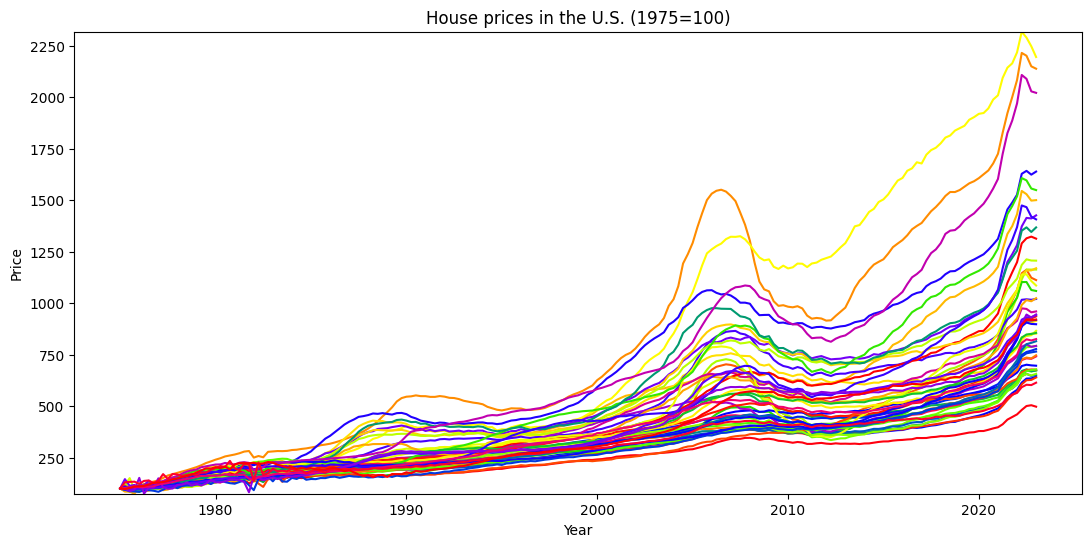

In [50]:
plt.figure(figsize=(13,6))
plt.plot(Dates, PricePlot.iloc[:, 0], label=Prices.columns[0], color='blue')
plt.ylim(min(PricePlot.values.flatten()), max(PricePlot.values.flatten()))
plt.ylabel("Price")
plt.xlabel("Year")
plt.title("House prices in the U.S. (1975=100)")

for i in range(1, PricePlot.shape[1]):
    plt.plot(Dates, PricePlot.iloc[:, i], label=Prices.columns[i], color=plt.cm.prism(50 + i))

#plt.legend()
plt.show()

In [51]:
LatLong = pd.read_excel("LatLongUS.xlsx")
LatLong.shape

(52, 4)

In [52]:
LatLong = LatLong.drop(index=39).reset_index(drop=True)
LatLong.shape

(51, 4)

In [53]:
#Wmat = usaww / usaww
#Wmat = np.nan_to_num(Wmat) # Replace NaN values with 0
dPrice = Prices.apply(lambda x: (x - x.shift(1)) / x.shift(1), axis=0)
dPrice = dPrice.iloc[1:, :]  # Drop the first row
dPrice = dPrice.drop(dPrice.columns[[0, 11]], axis=1)  # Drop 1st and 12th columns
dPrice.head()  # View the result

State,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
1,-0.037323,-0.095431,-0.012535,0.025180,0.012740,0.008671,-0.005017,0.162924,0.265433,-0.025870,...,-0.062767,0.010143,0.053388,0.065639,-0.043814,-0.006076,0.019888,0.015034,0.300557,-0.027049
2,0.033232,0.078584,-0.007182,0.036491,-0.000729,-0.015282,-0.005882,0.291583,-0.199329,0.032258,...,-0.075501,-0.014115,-0.041638,-0.061256,0.010931,-0.127081,0.053836,0.028826,0.012856,0.047450
3,-0.039132,-0.032656,-0.052322,0.032724,0.003467,0.000323,0.155537,-0.380294,0.020958,-0.006870,...,-0.017841,0.046347,0.056624,0.085554,0.003407,0.085978,-0.033588,0.068731,0.008462,0.068449
4,0.075314,0.064013,0.046689,0.044580,0.000182,0.047188,-0.029078,0.109623,-0.003666,-0.031195,...,-0.015346,-0.008464,-0.011628,0.039406,0.024063,0.605790,0.048075,-0.051564,-0.078364,0.013635
5,-0.037354,0.026938,0.064959,0.051674,0.087620,-0.009722,-0.001507,0.061463,0.118175,0.022400,...,0.075223,-0.024755,0.083717,-0.011245,-0.011388,-0.508588,0.064535,-0.000916,0.115428,0.019716


Elbow detected at 9 clusters


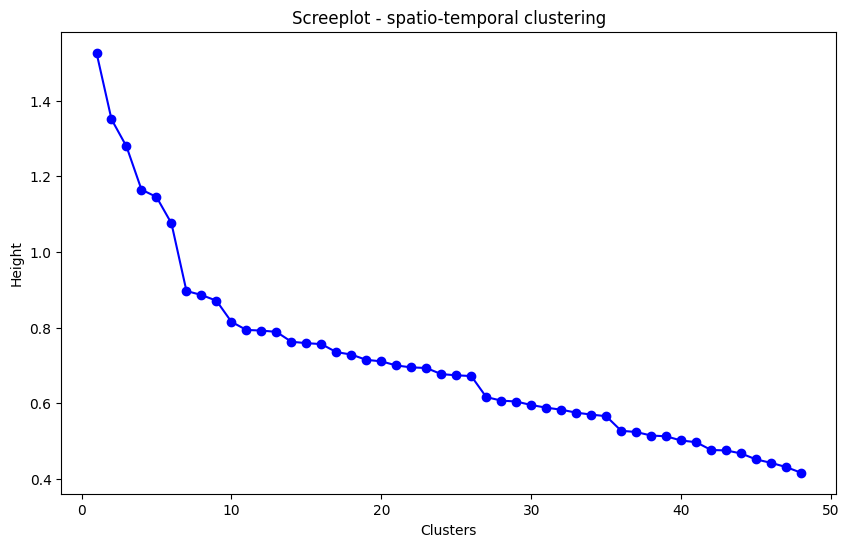

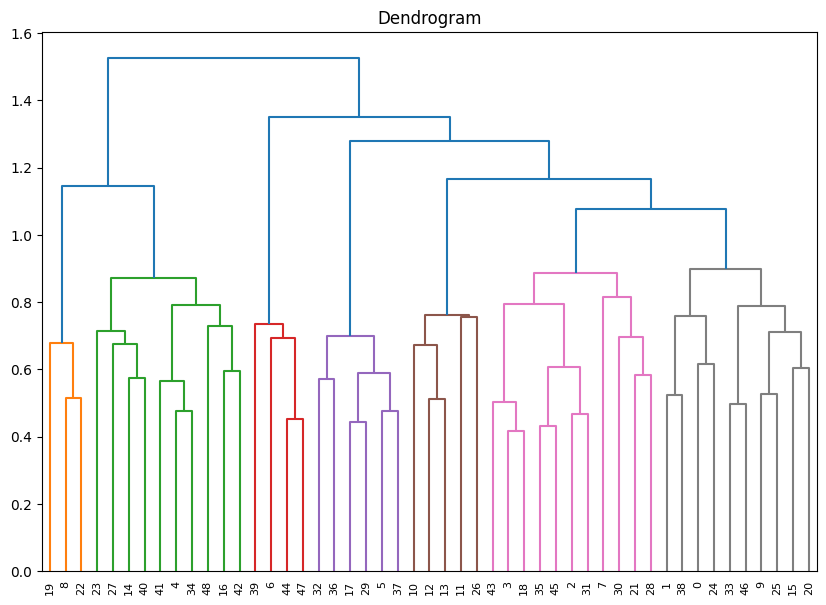

Elbow detected at 10 clusters
Elbow detected at 10 clusters
Elbow detected at 10 clusters
Elbow detected at 10 clusters


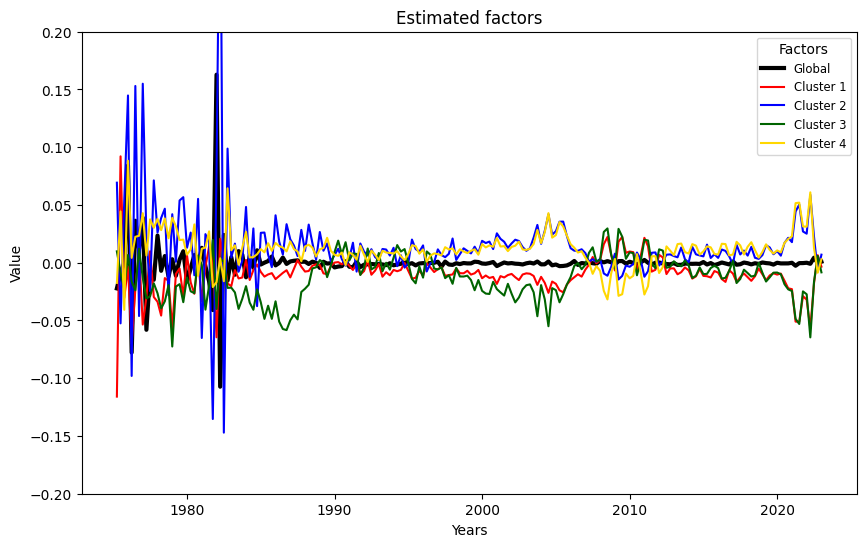

In [54]:
coords = LatLong.drop(index=[0, 11]).iloc[:, [1, 2]].values

# Convert dPrice to a NumPy array
data = dPrice.values

# Perform clustering using st_facm function
FullSample = st_facm(data, coords, typeD="COR")

# Extract the estimated factors
Global_Factors = FullSample["Global_Factors"]
Local_Factors = FullSample["Local_Factors"]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Dates[1:], Global_Factors, label="Global", color="black", linewidth=3)

# Add lines for each local factor
colors = ["red", "blue", "darkgreen", "gold", "purple", "orange", "brown", "pink", "gray", "cyan", "magenta"]
for i, factor in enumerate(Local_Factors):
    plt.plot(Dates[1:], factor, label=f"Cluster {i + 1}", color=colors[i])

# Add plot labels, title, and legend
plt.xlabel("Years")
plt.ylabel("Value")
plt.title("Estimated factors")
plt.ylim(-0.2, 0.2)
plt.legend(loc="upper right", fontsize="small", title="Factors")
plt.show()